Benchmarking xarray netcdf vs xarray zarr using Dask Local cluster.
Two chunking test cases for NetCDF is also in this notebook.

For general info on GFDL specific Python/Jupyter/Anaconda, please checkout http://wiki.gfdl.noaa.gov/Python. It also has information on port for
Data citation

Zhao, Ming; Blanton, Chris; John, Jasmin G; Radhakrishnan, Aparna; Zadeh, Niki T.; McHugh, Colleen; Rand, Kristopher; Vahlenkamp, Hans; Wilson, Chandin; Ginoux, Paul; Malyshev, Sergey; Wyman, Bruce; Guo, Huan; Balaji, V; Held, Isaac M; Dunne, John P.; Winton, Michael; Adcroft, Alistair; Milly, P.C.D; Shevliakova, Elena; Knutson, Thomas; Ploshay, Jeffrey; Zeng, Yujin (2018). NOAA-GFDL GFDL-CM4C192 model output prepared for CMIP6 HighResMIP. Version 20180701 [1].Earth System Grid Federation. https://doi.org/10.22033/ESGF/CMIP6.2262




User input: Dask analysis template

In [1]:
import os 
clusterType = "local" #or SLURM or Local
platform = "PPAN"
numCores = 8
numWorkers = 8
mem='48GB'
varname='tas'
dashPort = ':1984'
if (platform == "PPAN"):
    logdir = '/work/a1r/dask/logs/'
    localdir = '' #We will set local directory when we define the cluster
else:
    logdir = '/local2/home/a1r/logs/'
    localdir = logdir
print("Logs:", logdir)

res_nc = {} #settings, time
res_zarr = {} #settings, time

Logs: /work/a1r/dask/logs/


In [2]:
# get the plot in notebook
%matplotlib inline
import xarray as xr 

Use dask.distributed task scheduler and launch DASK using SLURMcluster

In [3]:
from dask.distributed import Client

#Instantiate Dask client
if (clusterType == "local"):
    from dask.distributed import LocalCluster
    cluster = LocalCluster(dashboard_address=dashPort,local_directory=localdir)
else:
    from dask_jobqueue import SLURMCluster
    scheduler_options = {}
    scheduler_options["dashboard_address"] = dashPort
    cluster = SLURMCluster(queue='batch',memory=mem,project='gfdl_f',cores=numCores,walltime='2:60:00',
                           scheduler_options=scheduler_options,log_directory=logdir,
                           local_directory=(os.getenv('TMPDIR'))) 
    
cluster.scale(numWorkers)
client = Client(cluster)    
client

Client Scheduler: tcp://127.0.0.1:36647 Dashboard: http://127.0.0.1:1984/status,Cluster Workers: 8 Cores: 32 Memory: 360.69 GB


In [4]:
dtype='zarr' #nc or zarr; TODO zipstore
if(dtype == 'zarr'):
    datadir = "/work/a1r/enes20/out/tas_3hr_2015-2051.zarr/"
else:
    datadir = '/work/a1r/enes20/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4C192/highresSST-future/r1i1p1f1/3hr/'+varname+'/gr3/v20180701/'

if(dtype == 'zarr'):
    customOptions = ""
     #Test1
    print("Case 1:",dtype,".",customOptions)
    %time ds = xr.open_zarr(datadir) 
     
elif(dtype == 'nc'):
    customOptions = "chunks={'time': 10}"
    print("Case 2:",dtype,".",customOptions)
    %time ds = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 10}, combine='by_coords',parallel=True,decode_cf=False)
else:
    sys.exit("Pass zarr or netcdf only")

Case 1: zarr . 
CPU times: user 412 ms, sys: 39 ms, total: 451 ms
Wall time: 845 ms


In [5]:
temp_mean = ds[varname].mean(dim=['time'])

CPU times: user 34 s, sys: 1.82 s, total: 35.8 s
Wall time: 39.3 s


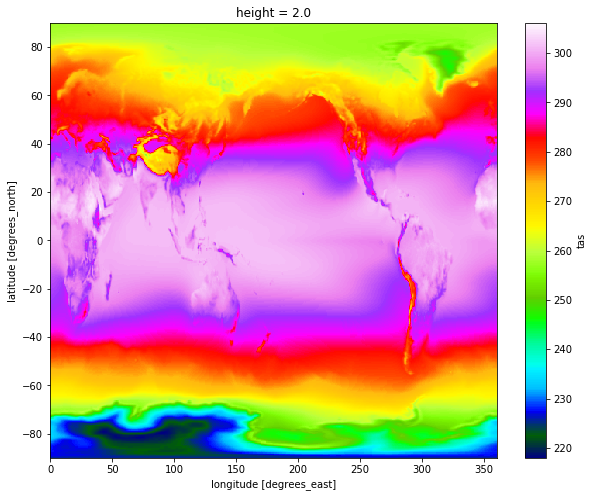

In [6]:
%time temp_mean.plot(figsize=[10, 8],cmap='gist_ncar') 

CPU times: user 26.6 s, sys: 1.13 s, total: 27.7 s
Wall time: 31.4 s


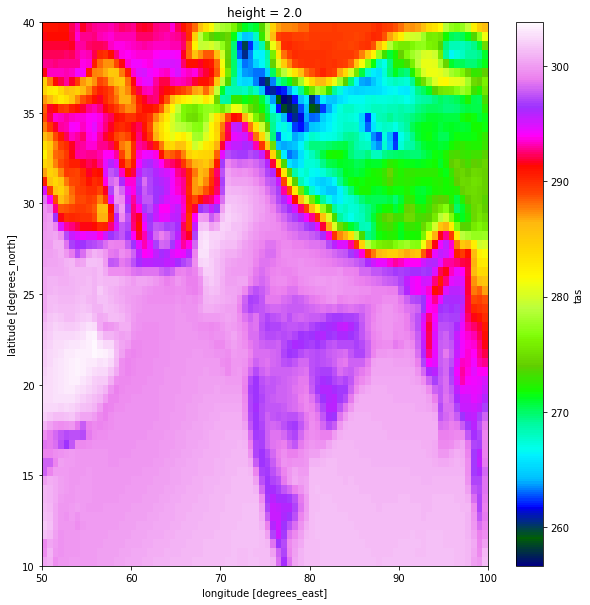

In [7]:
#India
%time temp_mean.loc[10:40,50:100].plot(figsize=[10, 10],cmap='gist_ncar')

In [8]:
#Case2: 
dtype='nc' #nc or zarr; TODO zipstore
if(dtype == 'zarr'):
    datadir = "/work/a1r/enes20/out/tas_3hr_2015-2051.zarr/"
else:
    datadir = '/work/a1r/enes20/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4C192/highresSST-future/r1i1p1f1/3hr/'+varname+'/gr3/v20180701/'

if(dtype == 'zarr'):
    customOptions = ""
     #Test1
    print("Case 1:",dtype,".",customOptions)
    %time ds = xr.open_zarr(datadir) 
     
elif(dtype == 'nc'):
    customOptions = "chunks={'time': 10}"
    print("Case 2:",dtype,".",customOptions)
    %time ds = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 10}, combine='by_coords',parallel=True,decode_cf=False)
else:
    sys.exit("Pass zarr or netcdf only")


Case 2: nc . chunks={'time': 10}
CPU times: user 463 ms, sys: 25 ms, total: 488 ms
Wall time: 1.87 s


In [9]:
temp_mean = ds[varname].mean(dim=['time'])

CPU times: user 43.7 s, sys: 2.24 s, total: 46 s
Wall time: 46 s


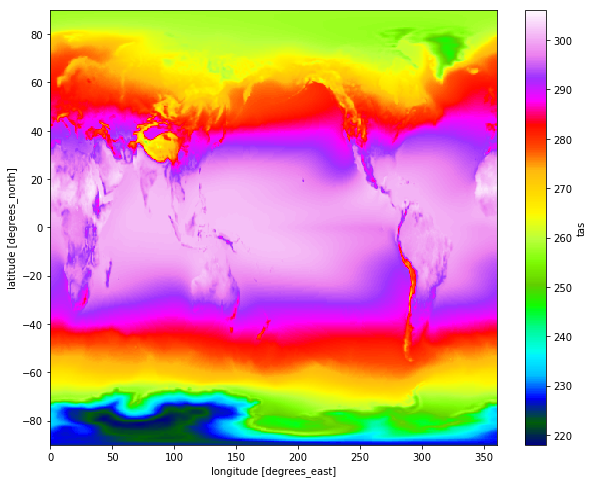

In [10]:
%time temp_mean.plot(figsize=[10, 8],cmap='gist_ncar') 

CPU times: user 44 s, sys: 2.14 s, total: 46.2 s
Wall time: 46.1 s


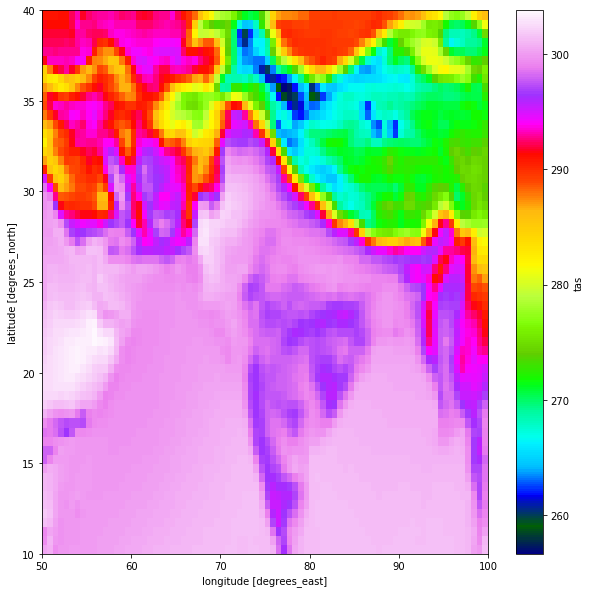

In [11]:
%time temp_mean.loc[10:40,50:100].plot(figsize=[10, 10],cmap='gist_ncar')#took 2 min 38seconds chunk on creation 

In [12]:
#LocalCluster
#8 workers
#8 cpu cores
#NetCDF chunk size 10, 360, 576
res_zarr["Open dataset"] = "1.06s"
res_nc["Open dataset"] = "3.75s"  
res_zarr["Time average plot"] = "40s"
res_nc["Time average plot"] = "1m4s"
res_zarr["Let's zoom in to a region"] = "47.8"
res_nc["Let's zoom in to a region"] = "32.2s"




In [13]:
#Zarr ds chunks (time, lat, lon) float32 dask.array<chunksize=(10, 360, 576)
for k,v in res_zarr.items():
    print("Operation   ","  Zarr  ", "NetCDF")
    print(k,":",v,"", res_nc[k])

Operation      Zarr   NetCDF
Open dataset : 1.06s  3.75s
Operation      Zarr   NetCDF
Time average plot : 40s  1m4s
Operation      Zarr   NetCDF
Let's zoom in to a region : 47.8  32.2s


Case 3, %time ds2 = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 240}, combine='by_coords',parallel=True,decode_cf=False)

In [14]:
%time ds2 = xr.open_mfdataset(datadir + '*.nc', chunks={'time': 240}, combine='by_coords',parallel=True,decode_cf=False)

CPU times: user 148 ms, sys: 11 ms, total: 159 ms
Wall time: 1.34 s


CPU times: user 44.1 s, sys: 2.13 s, total: 46.2 s
Wall time: 46.1 s


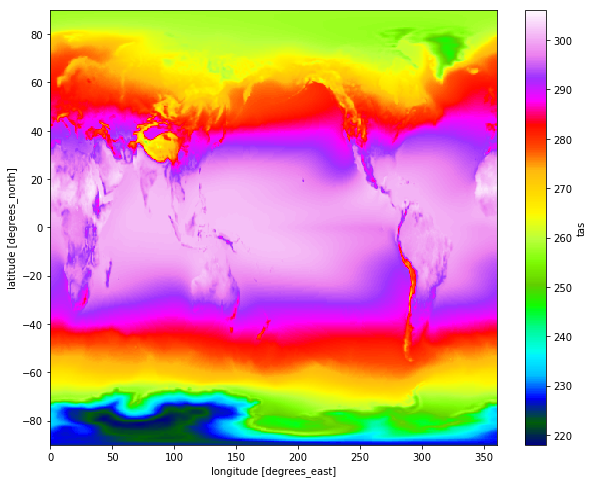

In [15]:
%time temp_mean.plot(figsize=[10, 8],cmap='gist_ncar') 

CPU times: user 44.2 s, sys: 2.15 s, total: 46.3 s
Wall time: 46.3 s


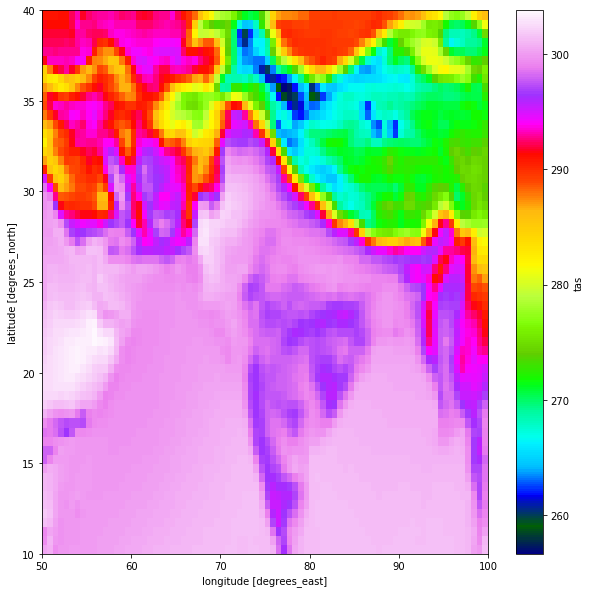

In [16]:
%time temp_mean.loc[10:40,50:100].plot(figsize=[10, 10],cmap='gist_ncar')#took 2 min 38seconds chunk on creation 

In [17]:
client.close()
cluster.close()

In [18]:
#If we use chunks time:240 
#Open takes 1.46s
#Time ave plot takes 46.1seconds
#Plot a specific region takes 46s